# 1. VERİ YOLU VE KÜTÜPHANELERİN YÜKLENMESİ

### 1.1- Data Setlerimizin Yolu:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 - Gerekli Kütüphaneler

In [4]:
import numpy as np
from skimage import exposure, filters
import matplotlib.pyplot as plt
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.mixture import GaussianMixture
from shapely.geometry import Polygon
import cv2
from brisque import BRISQUE  # BRISQUE skoru için

# 2. ÖN İŞLEME (Skor)
## Pipeline 1: Min-Max Norm + Sobel Keskinleştirme + Gürültü Azaltma + Histogram Eşitleme + Gamma Dönüşümü

### 2.1 Ön işleme yöntemlerinin oluşturulması

En iyi Pipeline: 1 (BRISQUE Skoru: 18.81)


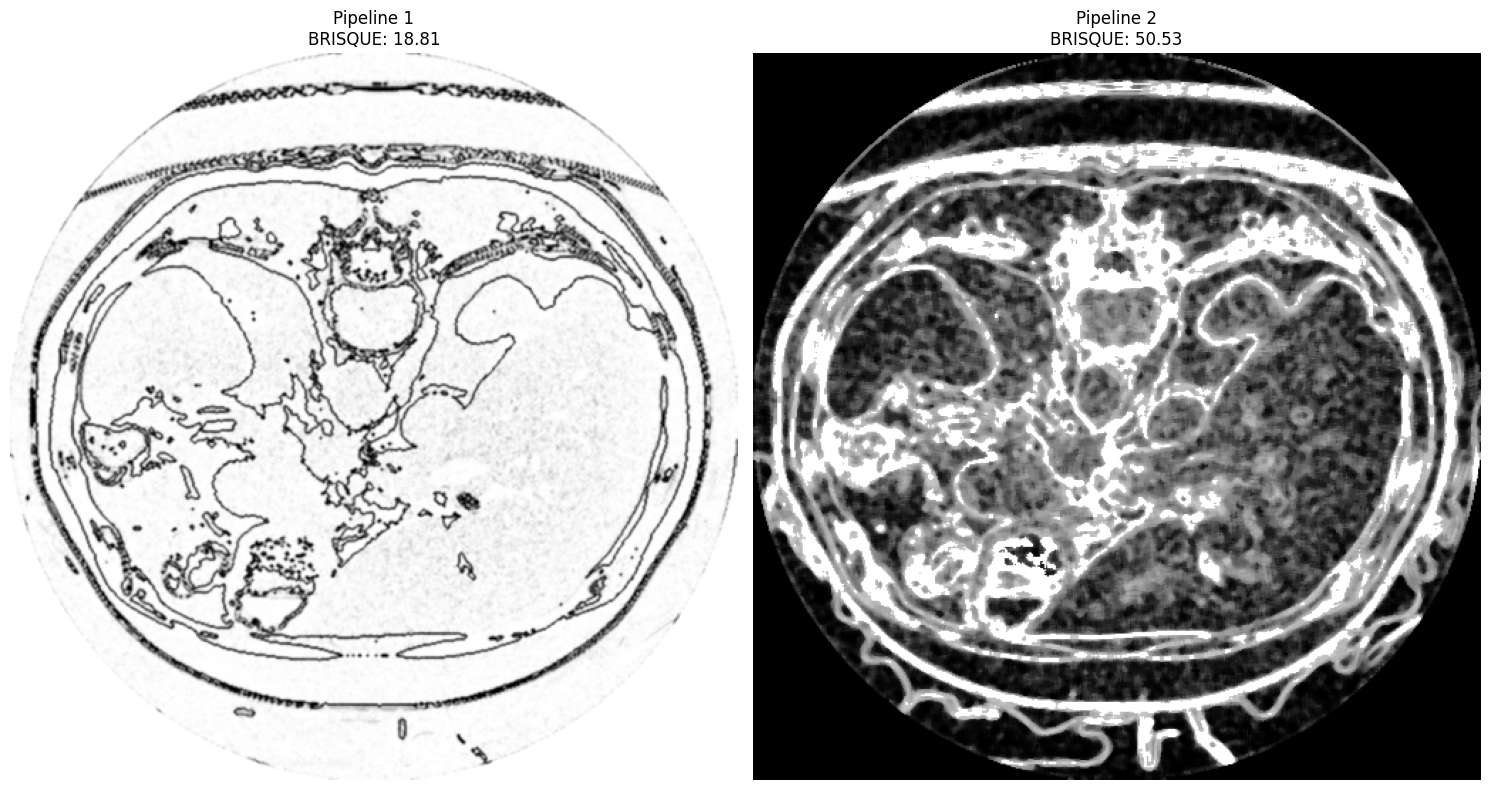

In [5]:


# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image, pipeline):
    if pipeline == 1:
        # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
        laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
        smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
        final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

        # Siyah ve beyaz renkleri tersine çevirme
        final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    elif pipeline == 2:
        # Pipeline 2: Min-Max Norm + Sobel Keskinleştirme + Median Blur + Histogram Eşitleme + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        sobel_image = sobel_sharpen((norm_image).astype(np.uint8))
        smoothed_image = cv2.medianBlur(sobel_image, 5)  # Daha güçlü Denoising
        final_image = cv2.equalizeHist(smoothed_image)  # Histogram Eşitleme
        final_image = apply_gamma(final_image, gamma=1.2).astype(np.uint8)  # Orta düzeyde parlaklık

    else:
        raise ValueError("Unsupported pipeline")

    return final_image

# Pipeline'ları değerlendirme
def main_pipeline_evaluation(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    pipelines = [1, 2]
    results = {}

    for pipeline in pipelines:
        # Pipeline'ı uygula
        processed_image = apply_pipeline(image, pipeline)

        # BRISQUE metriği ile değerlendirme
        processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
        brisque_score = BRISQUE().score(processed_image_3_channel)
        results[pipeline] = (processed_image, brisque_score)

    # En iyi pipeline'ı seç
    best_pipeline = min(results, key=lambda x: results[x][1])
    print(f"En iyi Pipeline: {best_pipeline} (BRISQUE Skoru: {results[best_pipeline][1]:.2f})")

    # Görüntüleri gösterme
    plt.figure(figsize=(15, 10))
    for i, pipeline in enumerate(pipelines, start=1):
        plt.subplot(1, len(pipelines), i)
        plt.title(f"Pipeline {pipeline}\nBRISQUE: {results[pipeline][1]:.2f}")
        plt.imshow(results[pipeline][0], cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Kullanım
image_path = "/content/drive/MyDrive/images/FLARE22_Tr_0001_slice_60.png"  # Görüntü yolunu doğru ayarlayın
main_pipeline_evaluation(image_path)


In [6]:
# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        raise ValueError("Unsupported normalization method")


# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0


### 2.2 Ön İşlemenin Uygulanması

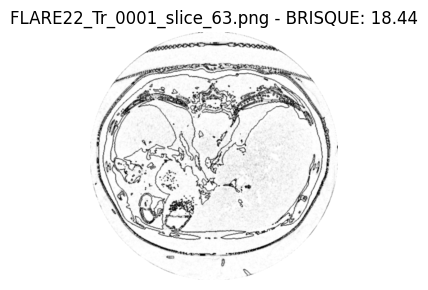

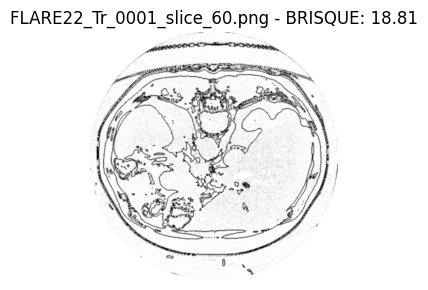

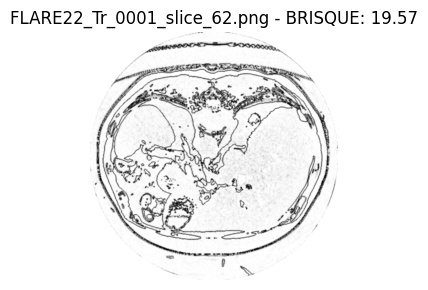

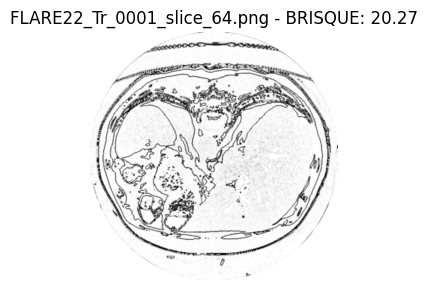

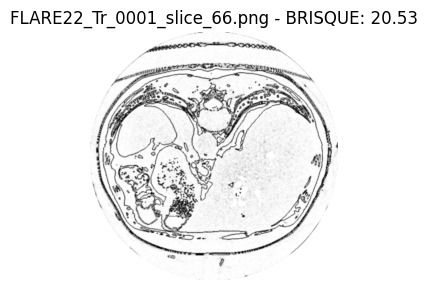

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from brisque import BRISQUE  # BRISQUE'yi doğru şekilde içe aktardığınızı varsayıyorum

# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image):
    # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
    norm_image = normalize(image, method="minmax")
    adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
    laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
    smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
    final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

    # Siyah ve beyaz renkleri tersine çevirme
    final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    return final_image

# Görüntüyü değerlendirme fonksiyonu
def evaluate_image(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    # Pipeline'ı uygula
    processed_image = apply_pipeline(image)

    # BRISQUE metriği ile değerlendirme
    processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
    brisque_score = BRISQUE().score(processed_image_3_channel)

    return brisque_score, processed_image

# Belirtilen dizindeki ilk 100 görüntüyü işleme fonksiyonu
def evaluate_images_in_directory(directory_path):
    scores = []  # Skorları tutacak liste

    count = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Sadece görüntü dosyalarını işleme al
            image_path = os.path.join(directory_path, filename)
            brisque_score, processed_image = evaluate_image(image_path)
            scores.append((brisque_score, processed_image, filename))  # Skor ve görüntüyü kaydet

            count += 1

            if count >= 50:  # Sadece ilk 50 görüntüyü işle
                break

    # En düşük BRISQUE skoruna sahip olanları sıralama ve en düşük 5'u alma
    lowest_scores = sorted(scores, key=lambda x: x[0])[:5]

    return lowest_scores

# Kullanım
directory_path = "/content/drive/MyDrive/images"
big5img = evaluate_images_in_directory(directory_path)

# En düşük skora sahip görüntüleri gösterme
for score, image, filename in big5img:
    plt.figure(figsize=(3, 3))
    plt.title(f"{filename} - BRISQUE: {score:.2f}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 3. Desen Kodlama

### 3.1 En iyi 3 görselin ve labeli ile noktasal çarpımı

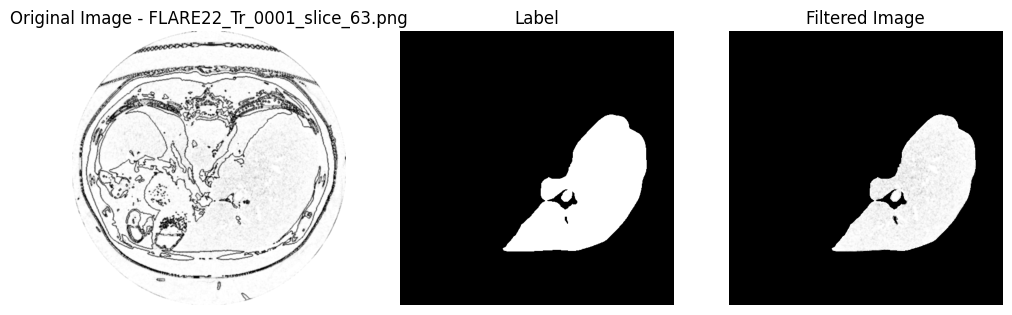

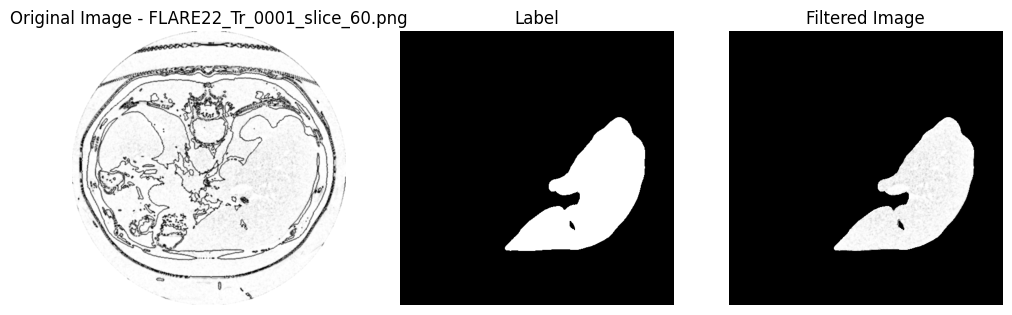

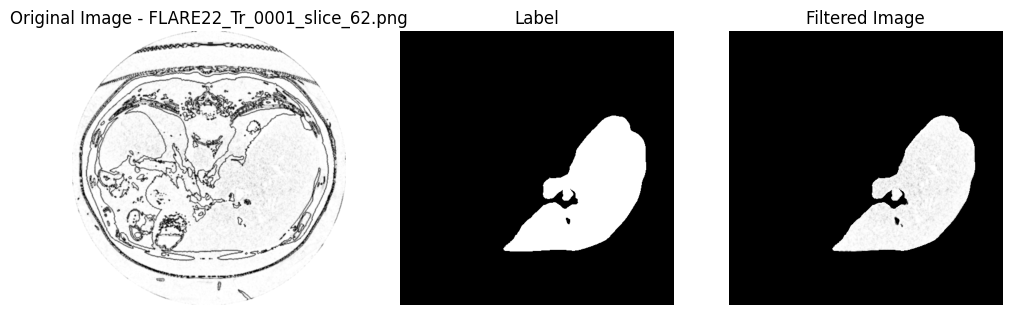

In [19]:
# Görsel ve label eşleştirme fonksiyonu
def process_big5img(lowest_scores, label_directory):
    count = 0
    for score, image, filename in lowest_scores:
        count += 1

        # Etiketi eşleştir
        label_path = os.path.join(label_directory, filename)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if label is None:
            print(f"Warning: Label not found for {filename}")
            continue

        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)

        # Görselleri çizdir
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image - {filename}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Filtered Image")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

        plt.show()
        if count >= 3:  # Sadece ilk 5 görüntüyü işle
            break

# Label dizini
label_directory_path = "/content/drive/MyDrive/labels"

# En düşük BRISQUE skorlarına sahip görsellerle işlem yap
process_big5img(big5img, label_directory_path)


### 3.2 Kullanılacak metodların oluşturulması

In [ ]:
def isolate_kidney(image, label):
    return cv2.bitwise_and(image, image, mask=label)

def detect_keypoints_and_descriptors(image, method="SIFT"):
    if method == "SIFT":
        detector = cv2.SIFT_create()
    elif method == "ORB":
        detector = cv2.ORB_create()
    elif method == "AKAZE":
        detector = cv2.AKAZE_create()
    else:
        raise ValueError("Unsupported method.")

    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

def extract_hog(image):
    return hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

def extract_lbp(image, radius=1, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp.ravel()

def gmm_modeling(descriptors, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(descriptors)
    return gmm

def match_keypoints(descriptors1, descriptors2, method="BF"):
    if method == "BF":
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    elif method == "FLANN":
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    else:
        raise ValueError("Unsupported method.")

    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def create_polygon_from_keypoints(keypoints, image_shape):
    points = np.array([kp.pt for kp in keypoints], dtype=np.int32)
    mask = np.zeros(image_shape, dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)
    return mask

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

In [ ]:
def evaluate_combinations(image, label, test_images, methods, features):
    best_iou = 0
    best_combination = None
    results = []  # IoU sonuçlarını saklamak için liste

    for method in methods:
        for feature in features:
            ious = []
            keypoints, descriptors = detect_keypoints_and_descriptors(image, method=method)

            # Özellik çıkarma işlemi
            if feature == "HoG":
                descriptor_features = extract_hog(image)
            elif feature == "LBP":
                descriptor_features = extract_lbp(image)
            elif feature == "GMM":
                gmm = gmm_modeling(descriptors)
                descriptor_features = gmm.means_

            # Test görüntüleri için IoU hesaplama
            for test_image in test_images:
                if test_image is not None:
                    test_keypoints, test_descriptors = detect_keypoints_and_descriptors(test_image, method=method)
                    matches = match_keypoints(descriptors, test_descriptors)
                    test_mask = create_polygon_from_keypoints(
                        [test_keypoints[m.trainIdx] for m in matches],
                        image.shape,
                    )
                    iou = calculate_iou(label, test_mask)
                    ious.append(iou)
                else:
                    print("Warning: Could not load a test image. Skipping.")

            # Ortalama IoU hesaplama
            mean_iou = np.mean(ious) if ious else 0  # Eğer IoU boşsa sıfır ata
            results.append((method, feature, mean_iou))  # Sonuçları sakla

            # En iyi IoU ve kombinasyonu bulma
            if mean_iou > best_iou:
                best_iou = mean_iou
                best_combination = (method, feature)

    return best_combination, best_iou, results


# big5img listesindeki görüntüleri ve etiketleri işle
label_directory = "/content/drive/Shareddrives/LeftKidneySegmentation/DB/labels"

methods = ["SIFT", "ORB", "AKAZE"]
features = ["HoG", "LBP", "GMM"]

for score, image, filename in big5img:
    # Görüntü ve etiket yollarını belirle
    label_path = os.path.join(label_directory, filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    if label is None:
        print(f"Warning: Label not found for {filename}. Skipping.")
        continue

    # Test görüntü yollarını oluştur
    test_image_paths = [
        f"/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/{filename}"
    ]
    test_images = [cv2.imread(path, 0) for path in test_image_paths]

    # Fonksiyonu çalıştır ve sonuçları al
    best_combination, best_iou, results = evaluate_combinations(
        image, label, test_images, methods, features
    )

    # Tüm kombinasyonları yazdır
    print(f"IoU Results for {filename}:")
    for method, feature, mean_iou in results:
        print(f"Method: {method}, Feature: {feature}, Mean IoU: {mean_iou:.4f}")

    # En iyi kombinasyonu yazdır
    print(f"\nBest Combination for {filename}: {best_combination}, IoU: {best_iou:.4f}")


In [ ]:
# Anahtar nokta tespiti ve görüntüleme fonksiyonu
def detect_and_show_keypoints(images, method="SIFT"):
    # Özellik çıkarıcıyı seç
    if method == "SIFT":
        feature_detector = cv2.SIFT_create()
    elif method == "ORB":
        feature_detector = cv2.ORB_create()
    elif method == "AKAZE":
        feature_detector = cv2.AKAZE_create()
    else:
        raise ValueError(f"Unknown method: {method}")

    # Her bir görselde anahtar noktaları tespit et ve göster
    for i, image in enumerate(images):
        if image is not None:
            keypoints, descriptors = feature_detector.detectAndCompute(image, None)

            # Anahtar noktaları görselleştir
            img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

            # Görseli matplotlib ile göster
            plt.figure(figsize=(8, 8))
            plt.imshow(img_with_keypoints, cmap='gray')
            plt.title(f"Keypoints - Image {i + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Warning: Image {i + 1} is None, skipping.")

# Görselleri ve etiketleri yükleyip noktasal çarpma
filtered_images = []
for img_path, lbl_path in zip(image_paths, label_paths):
    image = cv2.imread(img_path, 0)  # Gri seviyeli yükle
    label = cv2.imread(lbl_path, 0)  # Gri seviyeli yükle
    if image is not None and label is not None:
        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)
        filtered_images.append(filtered_image)
    else:
        print(f"Warning: Could not load image or label for {img_path}")

# Anahtar noktaları tespit et ve göster
detect_and_show_keypoints(filtered_images, method="ORB")


NameError: name 'image_paths' is not defined

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Anahtar nokta tespiti ve eşleştirme fonksiyonu
def detect_and_match_keypoints(train_images, test_images, method="SIFT"):
    # ... (Rest of the code remains the same) ...

    # Test görselleri ile eşleştirme yap
    for test_img in test_images:
        if test_img is not None:
            test_keypoints, test_descriptors = feature_detector.detectAndCompute(test_img, None)

            for i, train_desc in enumerate(descriptors_list):
                # Eşleşmeleri bul
                matches = bf.match(test_descriptors, train_desc)
                matches = sorted(matches, key=lambda x: x.distance)

                # Ensure num_matches_to_display is within bounds of both keypoint lists
                num_matches_to_display = min(10, len(matches), len(test_keypoints), len(keypoints_list[i]))

                # Görselleştirme
                if num_matches_to_display > 0: # Only draw matches if there are any
                    img_with_matches = cv2.drawMatches(test_img, test_keypoints, train_images[i], keypoints_list[i], matches[:num_matches_to_display], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img_with_matches)
                    plt.title("Keypoint Matches")
                    plt.axis('off')
                    plt.show()
                else:
                    print("Warning: No matches found to display.")
        else:
            print("Warning: Test image is None, skipping.")

    return matched_keypoints

# Test görsellerini yükleyin
test_image_paths = [
    "/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/amos_0001_slice_57.png",
    "/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/amos_0001_slice_58.png",
    "/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/amos_0001_slice_59.png",
    "/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/amos_0001_slice_60.png",
    "/content/drive/Shareddrives/LeftKidneySegmentation/DB/images/amos_0001_slice_61.png"
]
test_images = [cv2.imread(path, 0) for path in test_image_paths]

# Anahtar nokta eşleşmesini yap
matched_keypoints = detect_and_match_keypoints(filtered_images, test_images, method="ORB")

# Sonuçları görmek için eşleşmiş noktaları yazdırabilirsiniz
print(f"Matched Keypoints: {matched_keypoints}")


NameError: name 'feature_detector' is not defined